In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re

In [4]:
def generate_function(eq):
    func = re.sub(r' ', '', eq)
    func = re.sub(r'(\^)', '**', func)
    func = re.sub(r'x', '*x', func)
    func = re.sub(r'([\+]+\*)', '+', func)
    func = re.sub(r'([\-]+\*)', '-', func)
    func = re.sub(r'^(\*)', '', func)
    return(func)

In [5]:
def derivative(eq):
    func0 = eq.replace('x', '(x+(2*h))')
    func1 = eq.replace('x', '(x+h)')
    func = '-(' + func0 + '-4*(' + func1 + ')+3*(' + eq + '))/(2*h)'
    return(func)

## Método de Newton-Raphson

In [88]:
def newton_raphson(equation, x, tolerance):
    h = 0.000001
    
    log = pd.DataFrame(columns = ['Iteration', 'Xk', 'Xk+1', 'Error', 'F(x)', "F'(x)"])
    
    error = 100
    iteration = 0
    while error > tolerance:
        x_in = x
        x = x - (eval(generate_function(equation))/eval(derivative(generate_function(equation))))
        error = np.abs(x-x_in)
        iteration += 1

        log_info = {
            'Iteration' : iteration,
            'Xk' : x_in,
            'Xk+1' : x,
            'Error' : error,
            'F(x)' : eval(generate_function(equation)),
            "F'(x)" : eval(derivative(generate_function(equation)))
        }
        log = log.append(log_info, ignore_index=True)
        sol = [iteration, x, error]
        
    
    return(log, sol)

### Utilizando el método de Newton Raphson

f(x) = 4x^4 - 4x + 1

In [296]:
res, sol = newton_raphson('4x^4-4x+1', x = -1, tolerance = 1e-6)
res

,Iteration,Xk,Xk+1,Error,F(x),F'(x)
0,1.0,-1.000000,-0.550000,4.500000e-01,3.566025e+00,-6.662000
1,2.0,-0.550000,-0.014722,5.352784e-01,1.058886e+00,-4.000051
2,3.0,-0.014722,0.249997,2.647182e-01,1.563749e-02,-3.750010
3,4.0,0.249997,0.254167,4.169987e-03,2.637374e-05,-3.737291
4,5.0,0.254167,0.254174,7.056915e-06,7.721168e-11,-3.737269
5,6.0,0.254174,0.254174,2.065992e-11,0.000000e+00,-3.737269


#### Es mínimo **local** o **global**?

Respuesta Aqui

### Tasa de Convergencia

In [297]:
from sklearn.linear_model import LinearRegression

In [298]:
def convergence(result, solution, col):
    x_star = solution[1]
    df = pd.DataFrame()
    df_log = pd.DataFrame()
    ek = []
    for x in result[col]:
        ek.append(np.abs(x-x_star))

    df['ek'] = ek
    df['ek+1'] = df['ek'].shift(-1, fill_value = 0)
    
    df_log['ek'] = np.log(ek)
    df_log['ek+1'] = df_log['ek'].shift(-1, fill_value = 0)
    
    return(df, df_log)

In [299]:
data, data_log = convergence(res, sol, 'Xk')
data

,ek,ek+1
0,1.254174e+00,8.041737e-01
1,8.041737e-01,2.688953e-01
2,2.688953e-01,4.177044e-03
3,4.177044e-03,7.056936e-06
4,7.056936e-06,2.065992e-11
5,2.065992e-11,0.000000e+00


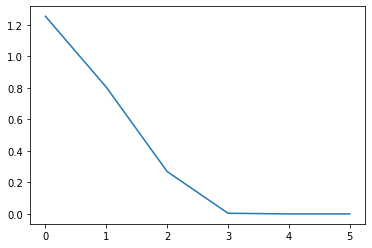

In [300]:
plt.plot(data['ek'])

Como podemos ver el error va decreciendo en cada iteración. Esta data luego debe de ser pasada a un Logaritmo Natural para poder realizar la regresión lineal

In [301]:
data_log

,ek,ek+1
0,0.226477,-0.217940
1,-0.217940,-1.313433
2,-1.313433,-5.478151
3,-5.478151,-11.861500
4,-11.861500,-24.602826
5,-24.602826,0.000000


Ya que tenemos la data convertida a logaritmo natural, podemos utilizar un modelo de regresión lineal para encontrar la tasa de convergencia (r) y la constante de la convergencia (C)

In [302]:
lm = LinearRegression()
lm.fit(data_log[['ek']], data_log[['ek+1']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [303]:
r = lm.coef_
print('La tasa de convergencia (r) es:', r[0][0])

La tasa de convergencia (r) es: 0.10916538632012417


In [304]:
C = np.exp(lm.intercept_)
print('La constante de convergencia (C) es:', C[0])

La constante de convergencia (C) es: 0.0015666918708918441


### Resultados método de Newton-Raphson

Finalmente, tenemos la función lineal entre los errores de la siguiente forma:

$ \ln|e_{k+1}| = r \ln|e_{k+1}| + \ln C $

Sustituyendo los resultados, podemos ver la ecuación de esta forma:

$ \ln|e_{k+1}| = 0.109165 \ln|e_{k+1}| + 0.0015667 $

## Método de la Bisección

In [305]:
def biseccion(eq, a, b, tolerance):
    
    log = pd.DataFrame(columns = ['Iteration', 'a', 'b', 'c', 'F(x)', 'error'])
    error = 100
    iteration = 1
    
    while error > tolerance:
        c = (a+b)/2
        a_in = a
        b_in = b
        
        x = a
        func_a = eval(generate_function(eq))
        x = c
        func_c = eval(generate_function(eq))
        
        if func_c == 0:
            log_info = {
                'Iteration': iteration,
                'a': a,
                'b': b,
                'c': c,
                'F(x)': func_c,
                'error': 0
            }
            log = log.append(log_info, ignore_index=True)
            break
        elif func_a * func_c < 0:
            b = c
        else:
            a = c            
        error = np.abs(func_c)
        
        log_info = {
            'Iteration': iteration,
            'a': a_in,
            'b': b_in,
            'c': c,
            'F(x)': eval(generate_function(eq)),
            'error': error
        }
        log = log.append(log_info, ignore_index=True)
        
        iteration += 1
        sol = [iteration, c, error]
    
    return(log, sol)

In [306]:
#df = biseccion('x^3 - 2x^2 - 1', 0, 4, 1e-8)
df, sol = biseccion('4x^4 - 4x + 1', 0, 1, 1e-6)
df

,Iteration,a,b,c,F(x),error
0,1.0,0.000000,1.000000,0.500000,-7.500000e-01,7.500000e-01
1,2.0,0.000000,0.500000,0.250000,1.562500e-02,1.562500e-02
2,3.0,0.250000,0.500000,0.375000,-4.208984e-01,4.208984e-01
3,4.0,0.250000,0.375000,0.312500,-2.118530e-01,2.118530e-01
4,5.0,0.250000,0.312500,0.281250,-9.997177e-02,9.997177e-02
5,6.0,0.250000,0.281250,0.265625,-4.258704e-02,4.258704e-02
6,7.0,0.250000,0.265625,0.257812,-1.357840e-02,1.357840e-02
7,8.0,0.250000,0.257812,0.253906,9.996900e-04,9.996900e-04
8,9.0,0.253906,0.257812,0.255859,-6.295348e-03,6.295348e-03
9,10.0,0.253906,0.255859,0.254883,-2.649316e-03,2.649316e-03


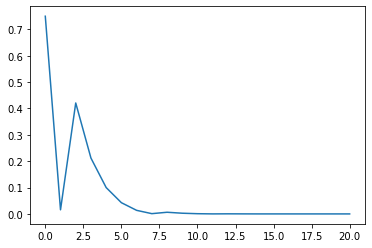

In [307]:
plt.plot(df['error'])

In [308]:
df, df_log = convergence(df, sol, 'c')

/Users/jjosue/anaconda3/envs/galileo_python/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


In [309]:
df_log = df_log.replace([np.inf, -np.inf], np.nan).dropna()
df_log

,ek,ek+1
0,-1.403130,-5.478939
1,-5.478939,-2.113402
2,-2.113402,-2.841703
3,-2.841703,-3.609099
4,-3.609099,-4.469657
5,-4.469657,-5.616117
6,-5.616117,-8.226370
7,-8.226370,-6.385622
8,-6.385622,-7.251575
9,-7.251575,-8.418364


In [310]:
lm = LinearRegression()
lm.fit(df_log[['ek']], df_log[['ek+1']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Ya que tenemos la data convertida a logaritmo natural, podemos utilizar un modelo de regresión lineal para encontrar la tasa de convergencia (r) y la constante de la convergencia (C)

In [311]:
r = lm.coef_
print('La tasa de convergencia (r) es:', r[0][0])

La tasa de convergencia (r) es: 0.8855704107638511


In [312]:
C = np.exp(lm.intercept_)
print('La constante de convergencia (C) es:', C[0])

La constante de convergencia (C) es: 0.20267490666030646


### Resultados método de Bisección

Finalmente, tenemos la función lineal entre los errores de la siguiente forma:

$ \ln|e_{k+1}| = r \ln|e_{k+1}| + \ln C $

Sustituyendo los resultados, podemos ver la ecuación de esta forma:

$ \ln|e_{k+1}| = 0.885570 \ln|e_{k+1}| + 0.202675 $

### Conclusiones

Podemos ver que tanto el método de Newton-Raphson como el método de la Bisección convergen a un mismo punto estacionario donde el error es menor a la tolerancia especificada.

#### Comparación de Resultados:

|Item                 |Newton-Raphson| Bisección    |
|---------------------|--------------|--------------|
|Punto estacionario   | 0.254174     | 0.254174     |
|Iteraciones          | 6            | 21           |
|Error                | 2.065992e-11 | 1.612722e-07 |
|Tasa de Convergencia | 0.109165     | 0.885570     |
|Constante            | 0.0015667    | 0.202675     |

El método de **Bisección** toma más que el triple de iteraciones que el método de **Newton-Raphson** pero obtiene un error más bajo y también una tasa de convergencia más alta.